In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 71.5 MB/s eta 0:00:00


In [ ]:
# Bibliotecas principais
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, lpSum, LpBinary, LpMaximize, PULP_CBC_CMD, LpStatus
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de display
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

print("✅ Bibliotecas carregadas.")


✅ Bibliotecas carregadas.


In [ ]:
# Carregar o dataset com as probabilidades e categorias
df_base = pd.read_csv("optimized_allocation_results.csv")

# Verificar colunas essenciais
colunas_esperadas = ["id", "predicted_proba", "risk_category", "simulated_cost", "true_label"]
colunas_presentes = all(col in df_base.columns for col in colunas_esperadas)

print("📋 Colunas encontradas:", list(df_base.columns))
print("✅ Estrutura válida para simulação?" , colunas_presentes)

# Visualizar as primeiras linhas
df_base.head(10)


📋 Colunas encontradas: ['true_label', 'predicted_proba', 'risk_category', 'simulated_cost', 'id', 'selecionado']
✅ Estrutura válida para simulação? True


,true_label,predicted_proba,risk_category,simulated_cost,id,selecionado
0,0,0.111904,baixo,202,0,0
1,0,0.611920,médio,535,1,1
2,0,0.076506,baixo,960,2,0
3,0,0.569426,médio,370,3,1
4,0,0.900693,alto,206,4,1
5,0,0.101867,baixo,171,5,0
6,1,0.857792,alto,800,6,1
7,0,0.104821,baixo,120,7,0
8,1,0.915652,alto,714,8,1
9,0,0.362694,médio,221,9,1


In [ ]:
def simular_alocacao(df, capacidade_max, orcamento_total, min_alto_risco,
                     peso_risco=1.0, peso_custo=0.001, verbose=False):
    """
    Executa uma simulação de alocação ótima com base nos parâmetros fornecidos.
    Retorna: DataFrame com decisões + métricas da solução.
    """
    df_sim = df.copy()
    ids = df_sim["id"].tolist()
    risco = dict(zip(df_sim["id"], df_sim["predicted_proba"]))
    custo = dict(zip(df_sim["id"], df_sim["simulated_cost"]))
    categoria = dict(zip(df_sim["id"], df_sim["risk_category"]))

    modelo = LpProblem("Simulacao_Alocacao", LpMaximize)
    x = {i: LpVariable(f"x_{i}", cat=LpBinary) for i in ids}

    # Função objetivo
    modelo += lpSum([peso_risco * risco[i] * x[i] - peso_custo * custo[i] * x[i] for i in ids])

    # Restrições
    modelo += lpSum([x[i] for i in ids]) <= capacidade_max, "Restricao_Capacidade"
    modelo += lpSum([custo[i] * x[i] for i in ids]) <= orcamento_total, "Restricao_Orcamento"
    ids_alto = [i for i in ids if categoria[i] == "alto"]
    modelo += lpSum([x[i] for i in ids_alto]) >= min_alto_risco, "Restricao_Alto_Risco"

    # Resolver
    status = modelo.solve(PULP_CBC_CMD(msg=False))
    df_sim["selecionado"] = df_sim["id"].apply(lambda i: int(x[i].varValue))

    # Métricas
    atendidos = df_sim["selecionado"].sum()
    risco_medio = df_sim[df_sim["selecionado"] == 1]["predicted_proba"].mean()
    custo_total = df_sim[df_sim["selecionado"] == 1]["simulated_cost"].sum()
    positivos = df_sim[(df_sim["selecionado"] == 1) & (df_sim["true_label"] == 1)].shape[0]
    altos = df_sim[(df_sim["selecionado"] == 1) & (df_sim["risk_category"] == "alto")].shape[0]

    if verbose:
        print(f"📊 Status: {LpStatus[modelo.status]}")
        print(f"👥 Atendidos: {atendidos}")
        print(f"🔥 Risco médio: {risco_medio:.4f}")
        print(f"💰 Custo total: R$ {custo_total}")
        print(f"✅ Positivos incluídos: {positivos}")
        print(f"🔺 Alto risco incluídos: {altos}")

    return df_sim, {
        "status": LpStatus[modelo.status],
        "atendidos": atendidos,
        "risco_medio": risco_medio,
        "custo_total": custo_total,
        "positivos": positivos,
        "alto_risco": altos
    }


In [ ]:
# Parâmetros base para teste
cenario_teste = {
    "capacidade_max": 30,
    "orcamento_total": 18000,
    "min_alto_risco": 10,
    "peso_risco": 1.0,
    "peso_custo": 0.001
}

# Rodar simulação
df_simulado, metricas = simular_alocacao(df_base, **cenario_teste, verbose=True)

# Visualizar as 10 primeiras linhas
df_simulado[df_simulado["selecionado"] == 1].head(10)


📊 Status: Optimal
👥 Atendidos: 30
🔥 Risco médio: 0.7889
💰 Custo total: R$ 14736
✅ Positivos incluídos: 24
🔺 Alto risco incluídos: 19


,true_label,predicted_proba,risk_category,simulated_cost,id,selecionado
1,0,0.611920,médio,535,1,1
3,0,0.569426,médio,370,3,1
4,0,0.900693,alto,206,4,1
6,1,0.857792,alto,800,6,1
8,1,0.915652,alto,714,8,1
9,0,0.362694,médio,221,9,1
10,1,0.882321,alto,566,10,1
11,1,0.442120,médio,314,11,1
13,1,0.918183,alto,558,13,1
15,1,0.890816,alto,472,15,1


In [ ]:
from itertools import product

# Geração de 120 cenários via produto cartesiano dos parâmetros
capacidades = [20, 30, 40, 50]
orcamentos = [10000, 15000, 18000, 20000, 25000]
altos_risco = [0, 5, 10]
pesos_custo = [0.0, 0.001]

cenarios = []
id_cenario = 1

for cap, orc, risco_min, p_custo in product(capacidades, orcamentos, altos_risco, pesos_custo):
    cenarios.append({
        "nome": f"Cen_{id_cenario:03d}",
        "capacidade_max": cap,
        "orcamento_total": orc,
        "min_alto_risco": risco_min,
        "peso_risco": 1.0,
        "peso_custo": p_custo
    })
    id_cenario += 1

print(f"✅ Total de cenários gerados: {len(cenarios)}")


✅ Total de cenários gerados: 120


In [ ]:
# Lista para armazenar os resultados
resultados = []

# Executar simulações para todos os 120 cenários
for c in cenarios:
    _, met = simular_alocacao(df_base,
                               capacidade_max=c["capacidade_max"],
                               orcamento_total=c["orcamento_total"],
                               min_alto_risco=c["min_alto_risco"],
                               peso_risco=c["peso_risco"],
                               peso_custo=c["peso_custo"])
    met["cenario"] = c["nome"]
    met["capacidade_max"] = c["capacidade_max"]
    met["orcamento_total"] = c["orcamento_total"]
    met["min_alto_risco"] = c["min_alto_risco"]
    met["peso_custo"] = c["peso_custo"]
    resultados.append(met)

# Resultado final em DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados.head(10)


,status,atendidos,risco_medio,custo_total,positivos,alto_risco,cenario,capacidade_max,orcamento_total,min_alto_risco,peso_custo
0,Optimal,20,0.875021,9920,18,18,Cen_001,20,10000,0,0.000
1,Optimal,20,0.845314,8829,17,15,Cen_002,20,10000,0,0.001
2,Optimal,20,0.875021,9920,18,18,Cen_003,20,10000,5,0.000
3,Optimal,20,0.845314,8829,17,15,Cen_004,20,10000,5,0.001
4,Optimal,20,0.875021,9920,18,18,Cen_005,20,10000,10,0.000
5,Optimal,20,0.845314,8829,17,15,Cen_006,20,10000,10,0.001
6,Optimal,20,0.895824,11475,19,20,Cen_007,20,15000,0,0.000
7,Optimal,20,0.845314,8829,17,15,Cen_008,20,15000,0,0.001
8,Optimal,20,0.895824,11475,19,20,Cen_009,20,15000,5,0.000
9,Optimal,20,0.845314,8829,17,15,Cen_010,20,15000,5,0.001


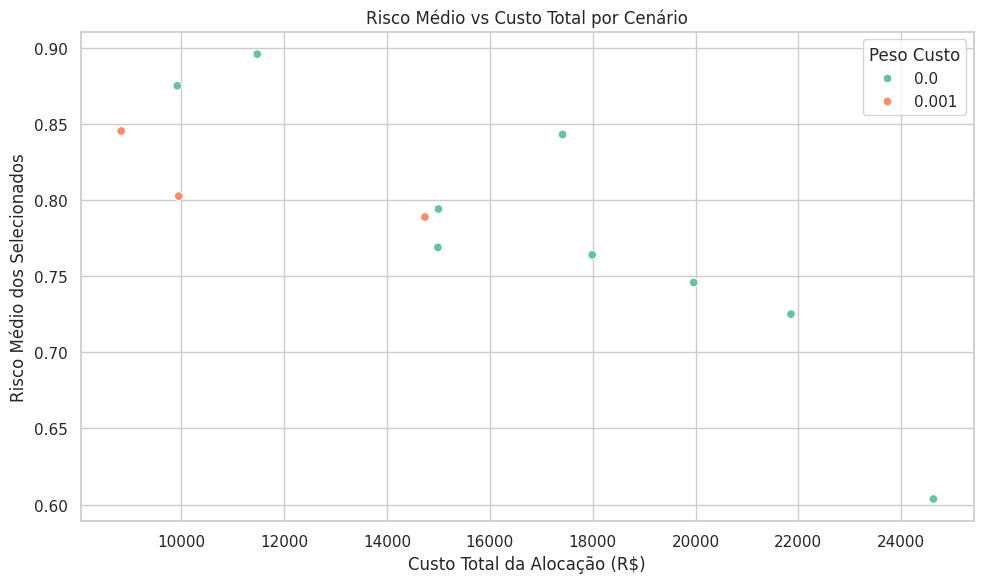

In [ ]:
# Gráfico de dispersão entre risco médio e custo total
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_resultados, x="custo_total", y="risco_medio", hue="peso_custo", palette="Set2")
plt.title("Risco Médio vs Custo Total por Cenário")
plt.xlabel("Custo Total da Alocação (R$)")
plt.ylabel("Risco Médio dos Selecionados")
plt.legend(title="Peso Custo")
plt.tight_layout()
plt.show()


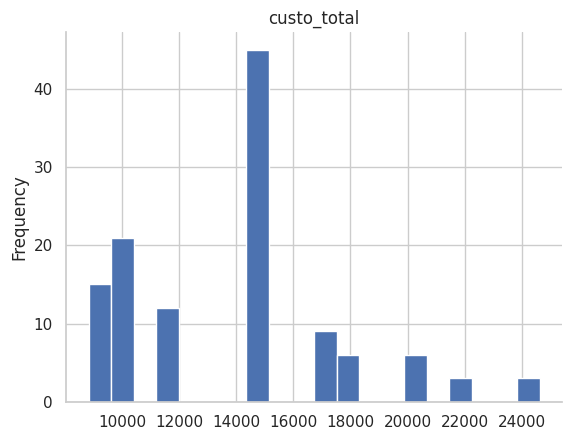

In [ ]:
# @title custo_total

from matplotlib import pyplot as plt
df_resultados['custo_total'].plot(kind='hist', bins=20, title='custo_total')
plt.gca().spines[['top', 'right',]].set_visible(False)

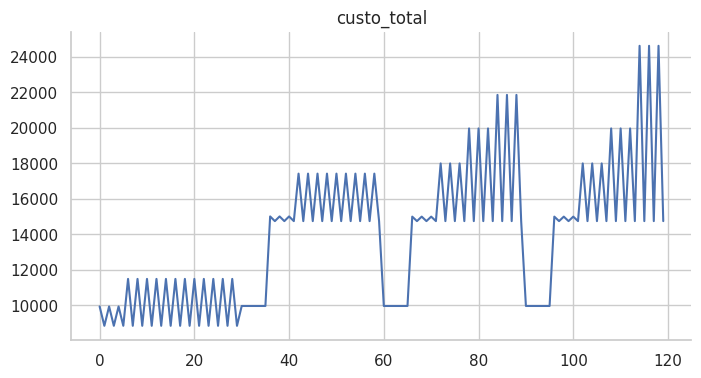

In [ ]:
# @title custo_total

from matplotlib import pyplot as plt
df_resultados['custo_total'].plot(kind='line', figsize=(8, 4), title='custo_total')
plt.gca().spines[['top', 'right']].set_visible(False)

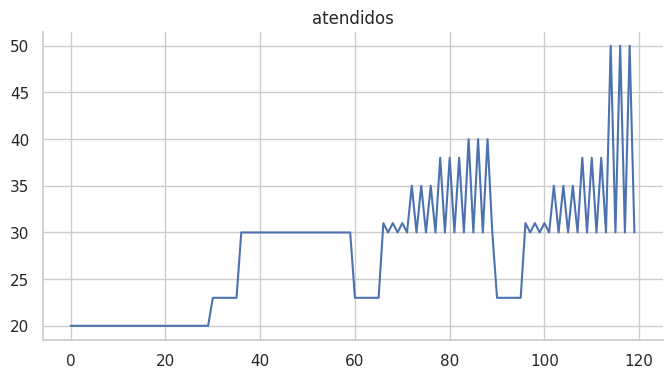

In [ ]:
# @title atendidos

from matplotlib import pyplot as plt
df_resultados['atendidos'].plot(kind='line', figsize=(8, 4), title='atendidos')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Salvar os resultados consolidados
df_resultados.to_csv("simulation_results_120cenarios.csv", index=False)
print("✅ Resultados exportados para 'simulation_results_120cenarios.csv'")


✅ Resultados exportados para 'simulation_results_120cenarios.csv'


In [ ]:
df_resultados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           120 non-null    object 
 1   atendidos        120 non-null    int64  
 2   risco_medio      120 non-null    float64
 3   custo_total      120 non-null    int64  
 4   positivos        120 non-null    int64  
 5   alto_risco       120 non-null    int64  
 6   cenario          120 non-null    object 
 7   capacidade_max   120 non-null    int64  
 8   orcamento_total  120 non-null    int64  
 9   min_alto_risco   120 non-null    int64  
 10  peso_custo       120 non-null    float64
dtypes: float64(2), int64(7), object(2)
memory usage: 10.4+ KB


In [ ]:
df_resultados.describe()

,atendidos,risco_medio,custo_total,positivos,alto_risco,capacidade_max,orcamento_total,min_alto_risco,peso_custo
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.0000,120.000000
mean,27.900000,0.804388,13902.600000,22.800000,18.425000,35.000000,17600.000000,5.0000,0.000500
std,6.731838,0.053496,3876.579052,4.135519,2.266536,11.227218,5024.979619,4.0996,0.000502
min,20.000000,0.603678,8829.000000,17.000000,15.000000,20.000000,10000.000000,0.0000,0.000000
25%,22.250000,0.788855,9948.000000,19.000000,15.000000,27.500000,15000.000000,0.0000,0.000000
50%,30.000000,0.791463,14736.000000,24.000000,19.000000,35.000000,18000.000000,5.0000,0.000500
75%,30.000000,0.843582,14991.750000,25.000000,20.000000,42.500000,20000.000000,10.0000,0.001000
max,50.000000,0.895824,24627.000000,31.000000,21.000000,50.000000,25000.000000,10.0000,0.001000
